In [1]:
cd ..

/Users/amiyaguchi/Research/wiki-forecast


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mapping = pd.read_csv("sample_data/trial_6/mapping.csv")
ts = pd.read_csv("sample_data/trial_6/ts.csv")

In [3]:
X = ts.iloc[:16,1:].fillna(1e-6).values
X.shape

(16, 608)

In [4]:
t = 0
training_size = 90
window_size = 28

# indices into the matrix
T = X.shape[1]
indices = [[i, j] for i, j in 
           zip(range(0, T, window_size), range(window_size, T, window_size))]

In [5]:
indices[:5]

[[0, 28], [28, 56], [56, 84], [84, 112], [112, 140]]

In [6]:
indexer = (
    np.arange(window_size).reshape(1, -1) 
    + window_size*np.arange(T//window_size).reshape(-1, 1)
)

In [7]:
indexer[:3]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
       [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]])

In [8]:
X[0][:100]

array([ 2072.,  1559.,  1735.,  1747.,  1965.,  1300.,  1367.,  1906.,
        2196., 15938., 43169., 16420.,  1297.,  1487., 12536.,  8281.,
       15586.,  7918.,  9611.,  1433.,  1609.,  3895.,  4940.,  5129.,
        5624.,  4261.,  1389.,  1567.,  2289.,  2676.,  8753.,  2248.,
        3521.,  1402.,  1366.,  4277.,  3170.,  7197.,  5052.,  3391.,
        1327.,  1833.,  2018.,  2107.,  2247.,  2031.,  1684.,  1330.,
        1334.,  2388., 17549.,  9340.,  9957., 23477.,  1452.,  5401.,
       15373., 21274.,  5589.,  3567.,  1897.,  3245.,  2985.,  2187.,
        2350.,  2319.,  2009.,  1934.,  1348.,  1568.,  2109.,  2282.,
        2130.,  2088.,  2007.,  1455.,  1402.,  2611.,  7665., 28170.,
        3717.,  4856.,  5769.,  1501.,  2200., 14501.,  6341., 16688.,
        1491.,  1362.,  7454.,  8818.,  3182.,  2068.,  2078.,  1710.,
        1241.,  1382.,  2192.,  1993.])

In [9]:
X[0,indexer][:3]

array([[ 2072.,  1559.,  1735.,  1747.,  1965.,  1300.,  1367.,  1906.,
         2196., 15938., 43169., 16420.,  1297.,  1487., 12536.,  8281.,
        15586.,  7918.,  9611.,  1433.,  1609.,  3895.,  4940.,  5129.,
         5624.,  4261.,  1389.,  1567.],
       [ 2289.,  2676.,  8753.,  2248.,  3521.,  1402.,  1366.,  4277.,
         3170.,  7197.,  5052.,  3391.,  1327.,  1833.,  2018.,  2107.,
         2247.,  2031.,  1684.,  1330.,  1334.,  2388., 17549.,  9340.,
         9957., 23477.,  1452.,  5401.],
       [15373., 21274.,  5589.,  3567.,  1897.,  3245.,  2985.,  2187.,
         2350.,  2319.,  2009.,  1934.,  1348.,  1568.,  2109.,  2282.,
         2130.,  2088.,  2007.,  1455.,  1402.,  2611.,  7665., 28170.,
         3717.,  4856.,  5769.,  1501.]])

In [10]:
X[0,indexer].shape

(21, 28)

In [11]:
X[:,indexer].shape

(16, 21, 28)

In [12]:
panes = X[:,indexer]
train = panes[:,0,:]
test = panes[:,1,:]
validate = panes[:,2,:]

rmse: 1882.2420100441389
mape: 0.14407008680489794


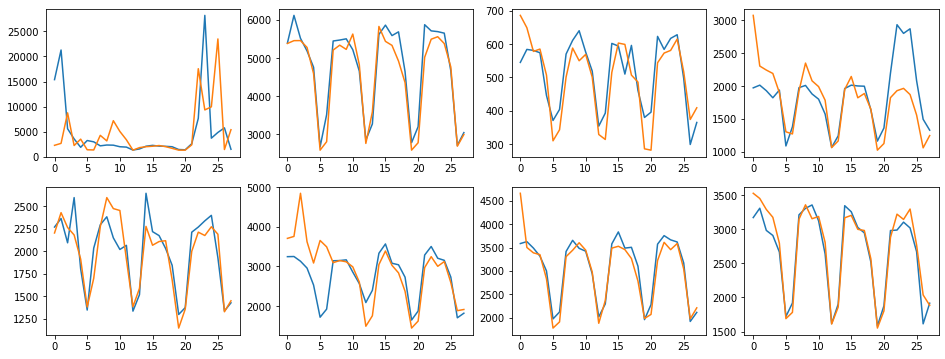

In [13]:
from sklearn import linear_model, kernel_ridge, metrics

def rmse(X, y):
    return np.sqrt(metrics.mean_squared_error(X, y))

def mape(X, y):
    return abs(np.divide(y - X, y)).sum()/y.size

def summarize(y, y_pred):
    print(f"rmse: {rmse(y, y_pred)}")
    print(f"mape: {mape(y, y_pred)}")
    plt.figure(figsize=(16, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.plot(y[i].T, label="y")
        plt.plot(y_pred[i].T, label="y_hat")
    plt.show()
    
summarize(validate, test)

rmse: 5884.686060820418
mape: 0.8834182599239939


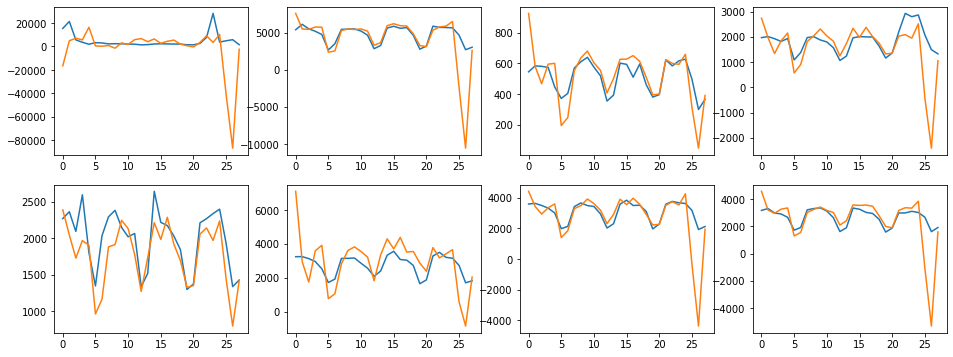

In [14]:
model = linear_model.LinearRegression()
model.fit(train, test)
summarize(validate, model.predict(test))

rmse: 1589.5576882804553
mape: 0.1600018972376527


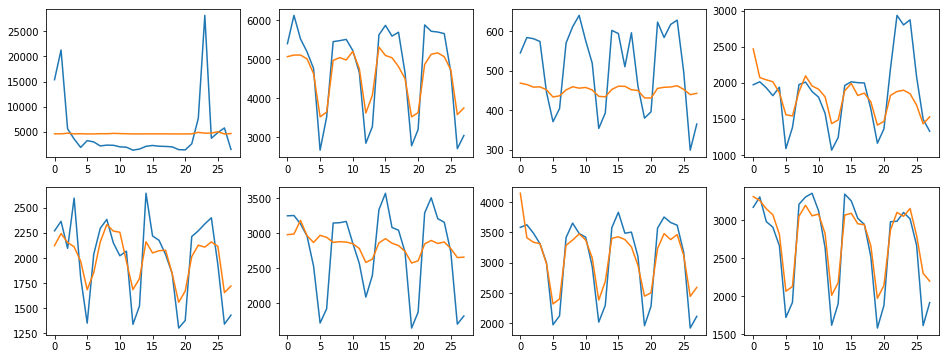

In [15]:
class IndependentLinearRegression:
    def fit(self, train, test):
        models = []
        for x,y in zip(train, test):
            reg = linear_model.LinearRegression()
            reg.fit(x.reshape(-1, 1) , y.reshape(-1, 1))
            models.append(reg)
        self.models = models
        
    def predict(self, X):
        if not self.models:
            raise RuntimeError()
            
        return np.array([model.predict(x.reshape(-1,1)).reshape(1,-1)[0] 
                         for model, x in zip(self.models, X)])

model = IndependentLinearRegression()
model.fit(train, test)
summarize(validate, model.predict(test))

rmse: 5884.620873286898
mape: 0.9462318297579484


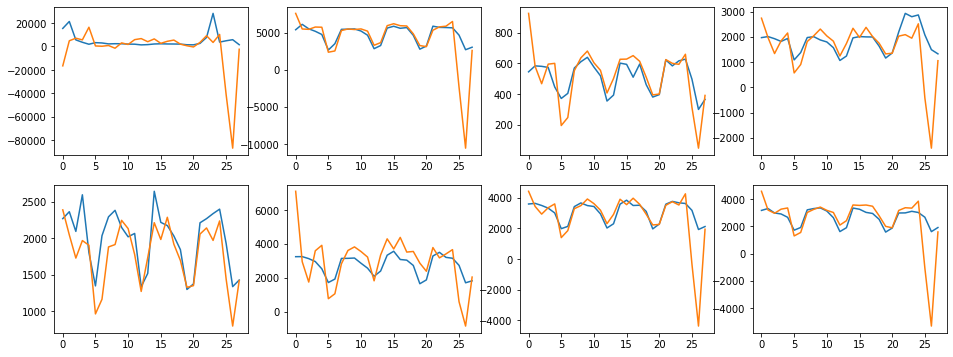

In [16]:
model = linear_model.Ridge(alpha=0.1)
model.fit(train, test)

y_pred = model.predict(test)
summarize(validate, model.predict(test))

rmse: 2147.7647536463446
mape: 0.7083857701095455


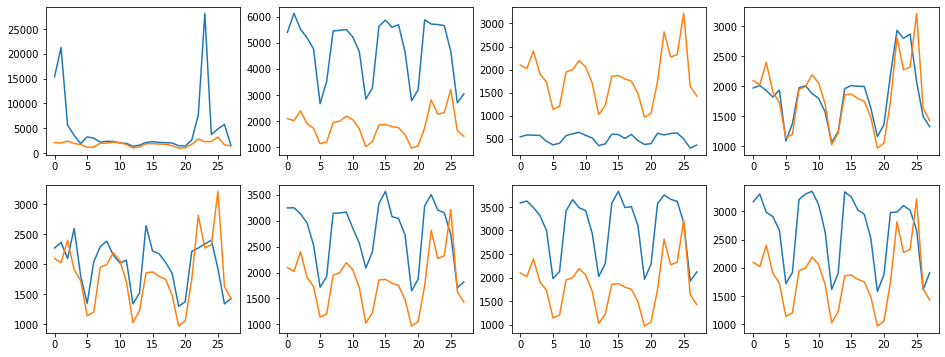

In [17]:
model = kernel_ridge.KernelRidge(kernel="sigmoid")
model.fit(train, test)
summarize(validate, model.predict(test))

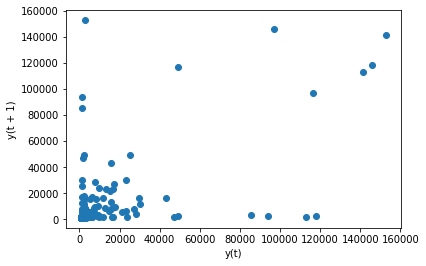

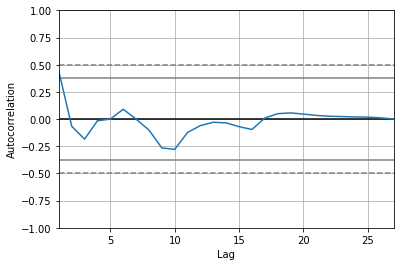

In [18]:
pd.plotting.lag_plot(ts.iloc[0, 1:].T)
plt.show()
pd.plotting.autocorrelation_plot(ts.iloc[0, 1:28].T)
plt.show()

rmse: 1603.1270664495175
mape: 0.17017021805506513


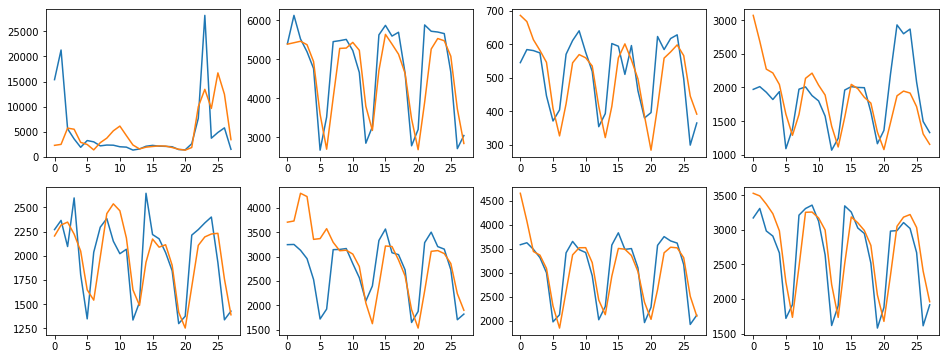

In [22]:
summarize(validate, pd.DataFrame(test.T).rolling(2, min_periods=1).mean().T.values)